In [1]:
### going to import household data and train a classifier on the data that takes as input the datetime information and outputs a daily load profile

import pandas as pd
import numpy as np
import os
os.chdir('..')
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
import holidays
import datetime

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from utils import *




In [2]:
def create_datetime_features(df):
    df['day_of_week'] = df.index.dayofweek / 7
    df['month'] = df.index.month / 12
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df.drop('month', axis=1, inplace=True)
    df['is_weekend'] = df.index.dayofweek.isin([5,6]).astype(int)
    return df

def create_holiday_features(df, df_holidays, df_holiday_periods=None):

    df_1 = days_until_next_holiday_encoder(df, df_holidays)

    df_2 = days_since_last_holiday_encoder(df, df_holidays)

    df_3 = pd.concat([df_1, df_2], axis=1)

    if df_holiday_periods is not None:
        df_3 = pd.concat([df_3, df_holiday_periods], axis=1)

    df_3 = df_3.loc[~df_3.index.duplicated(keep='first')]

    df_3 = df_3.reindex(df.index, fill_value=0)

    return df_3


def days_until_next_holiday_encoder(df, df_holidays):

    df_concat = pd.concat([df, df_holidays], axis=1)
    df_concat["days_until_next_holiday"] = 0
    for ind in df_concat.index:
        try:
            next_holiday = df_concat["holiday_dummy"].loc[ind:].first_valid_index()
            days_until_next_holiday = (next_holiday - ind).days
            df_concat.loc[ind, "days_until_next_holiday"] = days_until_next_holiday
        except:
            pass

    return df_concat[["days_until_next_holiday"]]


def days_since_last_holiday_encoder(df, df_holidays):

    df_concat = pd.concat([df, df_holidays], axis=1)
    df_concat["days_since_last_holiday"] = 0
    for ind in df_concat.index:
        next_holiday = df_concat["holiday_dummy"].loc[:ind].last_valid_index()
        days_since_last_holiday = (ind - next_holiday).days
        df_concat.loc[ind, "days_since_last_holiday"] = days_since_last_holiday

    return df_concat[["days_since_last_holiday"]]


def get_year_list(df):
    'Return the list of years in the historic data'
    years = df.index.year.unique()
    years = years.sort_values()
    return list(years)


def get_holidays(years, shortcut):

    country = getattr(holidays, shortcut)
    holidays_dict = country(years=years)
    df_holidays = pd.DataFrame(holidays_dict.values(), index=holidays_dict.keys())
    df_holidays[0] = 1
    df_holidays_dummies = df_holidays
    df_holidays_dummies.columns = ["holiday_dummy"]
    df_holidays_dummies.index = pd.DatetimeIndex(df_holidays.index)
    df_holidays_dummies = df_holidays_dummies.sort_index()

    return df_holidays_dummies

In [134]:
df = pd.read_csv(r'data\cleaned_data\5_household\power\SFH12_demand_W.csv', index_col=0, parse_dates=True)

scaler = MinMaxScaler()

df[df.columns] = scaler.fit_transform(df[df.columns])

df = timeseries_dataframe_pivot(df).dropna()

n_timesteps_per_day = df.shape[1]

SFH12    1.0
dtype: float64


In [115]:
# past information
def calc_rolling_sum_of_load(df, n_days):
    df['rolling_sum'] = df.sum(axis=1).rolling(n_days).sum().shift(1)
    df = df.dropna()
    return df

df = calc_rolling_sum_of_load(df, 7)


In [116]:
df["load_of_last_day"] = df.iloc[:,:-1].sum(axis=1).shift(1)


In [117]:
years = get_year_list(df)
df_holidays_dummies = get_holidays(years, "DE")
df_holidays = create_holiday_features(df, df_holidays_dummies)

In [118]:
df = create_datetime_features(df)
df = pd.concat([df, df_holidays], axis=1)
df_final = df.astype('float32')

In [119]:
n_features = df_final.shape[0] - n_timesteps_per_day

In [120]:
# split the data into train and test

train, test = train_test_split(df_final, test_size=0.2, shuffle=False)
train = train.values
test = test.values


In [121]:

# scale the data

scaler = MinMaxScaler()
train[:,-n_features:] = scaler.fit_transform(train[:,-n_features:])
test[:,-n_features:] = scaler.transform(test[:,-n_features:])

#features and target

X_train = train[:,n_timesteps_per_day:]
y_train = train[:,:n_timesteps_per_day]

X_test = test[:,n_timesteps_per_day:]
y_test = test[:,:n_timesteps_per_day]

# define the model
model = XGBRegressor(
    objective='reg:pseudohubererror'
    )



In [93]:

param_distributions = {'n_estimators': np.arange(100, 1000, 100),
                       'objective': ['reg:pseudohubererror', 'reg:squarederror','reg:tweedie'],
                       'max_depth': [9, 12],
                       'learning_rate': [0.001, 0.01,0.1],
                       'subsample': [0.5, 0.7, 0.9],
                       'colsample_bytree': [0.5, 0.7, 0.9],
                       'reg_alpha': [0, 0.1, 1, 10],
                       'reg_lambda': [0, 0.1, 1, 10]}

# define the search
search = RandomizedSearchCV(model, param_distributions, n_iter=100, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=3, random_state=42)

search.fit(X_train, y_train)
model = search.best_estimator_

In [122]:
model.fit(X_train, y_train)



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:pseudohubererror', predictor=None, ...)

In [123]:
predictions = model.predict(X_test)
predictions_reshaped = predictions.reshape(-1,1).flatten()
predictions_reshaped[predictions_reshaped < 0] = 0

# create benchmark that just shifts the data by 24 hours and pads the beginning with zeros

y_test_reshaped =  y_test.reshape(-1,1).flatten()

gt = pd.Series(y_test_reshaped)
benchmark_day = gt.shift(96).fillna(0)
benchmark_week = gt.shift(96*7).fillna(0)

In [124]:
df_compare = pd.DataFrame({'gt':gt, 
                            'predictions': predictions_reshaped,
                            'benchmark_day': benchmark_day,
                            'benchmark_week': benchmark_week}
                            )[96*7:]

px.line(df_compare,  title='XGBoost Regression')

In [125]:
calc_metrics(df_compare[7*96:], [mean_absolute_error, mean_squared_error, r2_score])



,mean_absolute_error,root_mean_squared_error,r2_score
gt,0.000000,0.000000,1.000000
predictions,0.112830,0.193214,-1.079071
benchmark_day,0.126697,0.241916,-0.506806
benchmark_week,0.123181,0.236820,-0.491053


In [109]:
benchmark_day_per_day = benchmark_day.values.reshape(predictions.shape)[7:]
benchmark_week_per_day = benchmark_week.values.reshape(predictions.shape)[7:]

### Visualization

<Axes: title={'center': 'Daily Sums of Load Profiles'}>

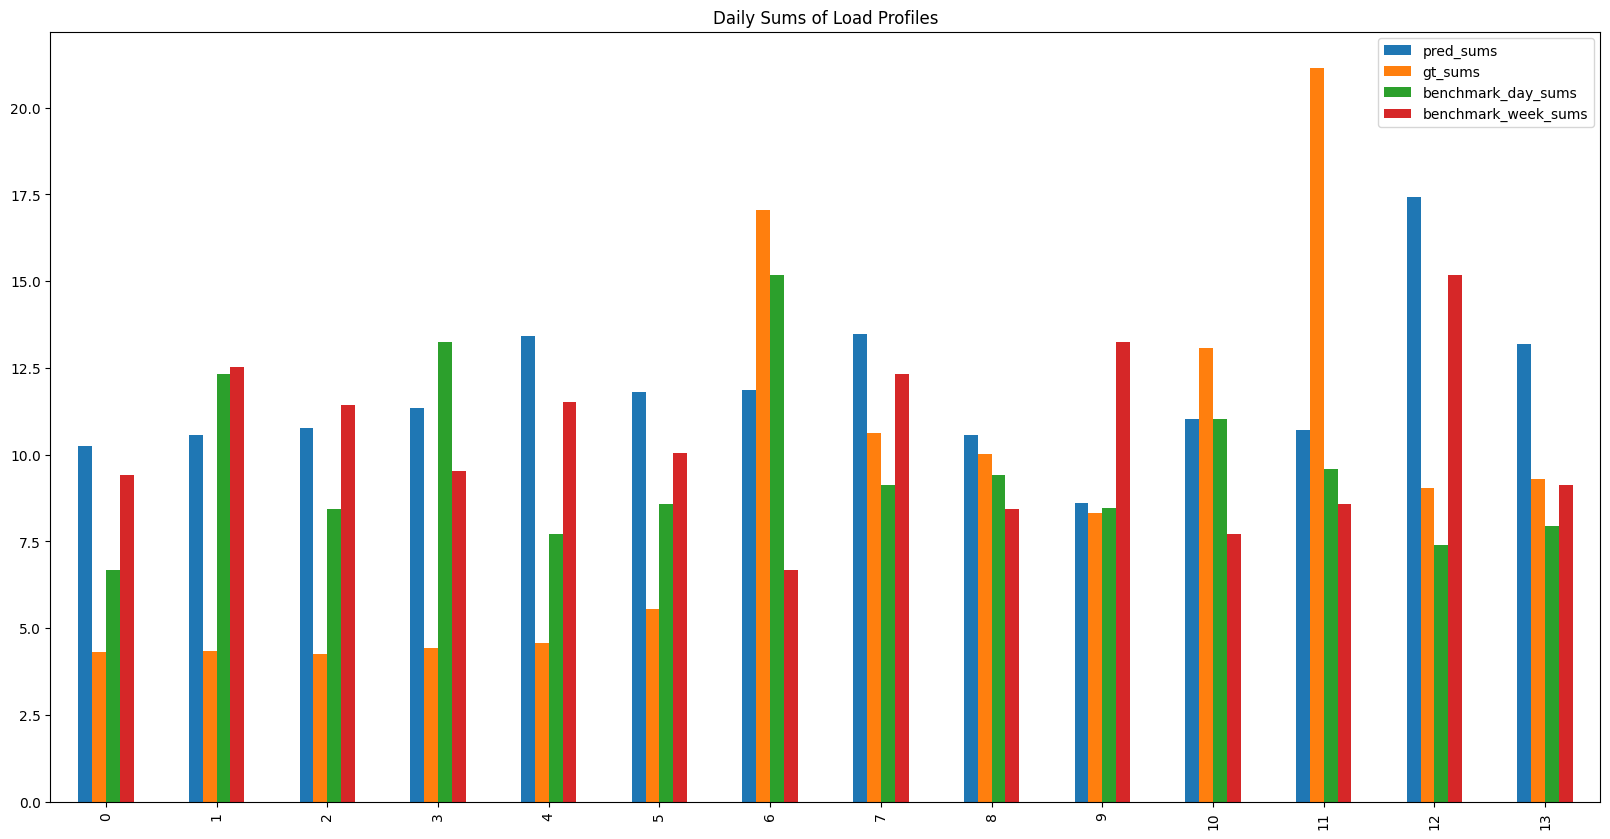

In [127]:
df_daily_sum = pd.DataFrame({'pred_sums': predictions.sum(axis=1)[7:], 
                            'gt_sums': y_test.sum(axis=1)[7:],
                            'benchmark_day_sums': benchmark_day_per_day.sum(axis=1),
                            'benchmark_week_sums': benchmark_week_per_day.sum(axis=1)
                             })[:14]


df_daily_sum.plot(title='Daily Sums of Load Profiles', kind='bar', figsize=(20,10))